In [8]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.pipeline import Pipeline

from sklearn.metrics import silhouette_score, calinski_harabasz_score,rand_score,adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer

Le clustering se fera avec KMeans avec 4 clusters.

#### Essai 2 - Injection des clients au fur et à mesure des commandes

In [47]:
customers_concat=pd.read_csv("data/saved_data/customers_concat.csv")

In [48]:
customers_concat.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')

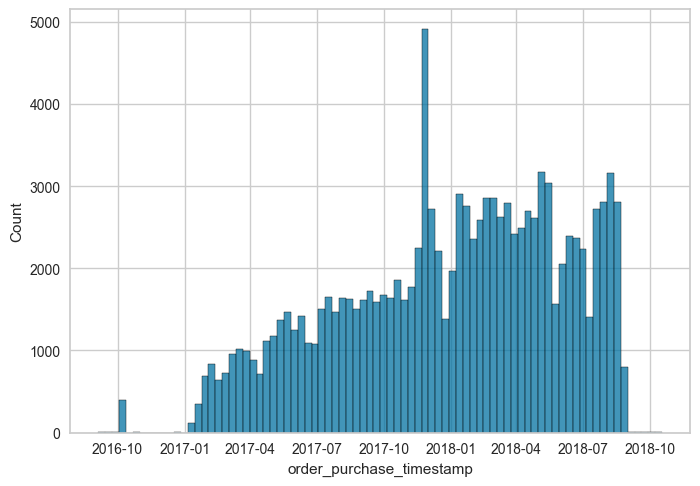

In [69]:
#Visualisation des dates de commande pour déterminer la date pour le premier modèle
sns.histplot(customers_concat['order_purchase_timestamp'])
plt.show()

In [77]:
customers_concat['order_purchase_timestamp'].describe()

count                           119143
mean     2017-12-29 18:36:13.115760384
min                2016-09-04 21:15:19
25%                2017-09-10 20:15:46
50%                2018-01-17 11:59:12
75%                2018-05-03 13:18:30
max                2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: object

In [54]:
def compute_rfm(customers_concat,last_date):
    # Filtrer sur commandes jusqu'à une certaine date
    customers_concat_extract=customers_concat[customers_concat['order_purchase_timestamp']<last_date]
    # Calculer le nombre de commandes par client:
    commandes_par_client=customers_concat_extract.groupby('customer_unique_id')['order_id'].nunique()
    # Calculer le montant moyen par client:
    montant_par_commande=customers_concat_extract.groupby(['customer_unique_id','order_id'])['payment_value'].mean()
    montant_par_client=montant_par_commande.groupby('customer_unique_id').sum()
    # Calculer récense
    customers_concat_extract.loc[:,'order_purchase_timestamp']=pd.to_datetime(customers_concat_extract['order_purchase_timestamp'])
    recense_par_client=customers_concat_extract.groupby('customer_unique_id')['order_purchase_timestamp'].max()
    #Transformer récense en un int correspondant au nombre de jours depuis la fin de la période étudiée
    recense_par_client=(pd.to_datetime("2019-01-01 00:00:00")-recense_par_client).round('d')
    recense_par_client=recense_par_client.astype('int64')/60/60/24/1000000000
    # Concatener les 3 indicateurs
    if ((montant_par_client.index==commandes_par_client.index).all())&((montant_par_client.index==recense_par_client.index).all()):
        rfm=pd.concat([montant_par_client,commandes_par_client,recense_par_client],axis=1)
    else:
        raise IndexError('Indexes not aligned')
    return rfm


In [56]:
compute_rfm(customers_concat,"2017-01-01")

,payment_value,order_id,order_purchase_timestamp
customer_unique_id,,,
0032c76b20340da25249092a268ce66c,144.940,1,817.0
009b0127b727ab0ba422f6d9604487c7,40.950,1,839.0
00f0b70fdcb8a6e1671b52a2472bd41f,116.990,1,818.0
01f156677184504063bd19739f924af1,784.800,1,812.0
0313291a6f4f16df04dcf819d88c38ef,112.780,1,813.0
...,...,...,...
ff39ae410be7f9b3a2457c546c6f67de,49.275,1,817.0
ff68ad2883e793597f1c343dd6505f5d,534.980,1,817.0
ff822e5e1322cef6c211ad8a0591999e,30.420,1,814.0


Le cas idéal serait de pouvoir entraîner le modèle avec un maximum d'historique, donc d'avoir la date initiale au plus proche de la dernière date où des commandes ont été effectuées en nombre suffisant (ie août 2018)

In [79]:
model = Pipeline([('scaler', StandardScaler()), ('estimator', KMeans(n_init=10,n_clusters=4))])
# Modèle initial fait avec les données antérieures au 01/01/2017 :
model_0 = Pipeline([('scaler', StandardScaler()), ('estimator', KMeans(n_init=10,n_clusters=4))])
date_0='2018-06-01'
model_0.fit(compute_rfm(customers_concat,date_0))

#Les prédiction suivantes seront faites tous les 15 jours :
dates=[pd.to_datetime(date_0)+pd.Timedelta(days=15*i) for i in range(1,10)]

# Modèles succesifs en ajoutant clients avec récense supérieure
rand_scores={}
for last_date in dates :
    X_extract=compute_rfm(customers_concat,last_date)
    pred_0=model_0.predict(X_extract)
    pred=model.fit_predict(X_extract)
    rand_scores[last_date]=adjusted_rand_score(pred_0,pred)
rand_scores=pd.DataFrame.from_dict(rand_scores,orient='index',columns=['ARI scores'])
rand_scores

,ARI scores
2018-06-16,0.954248
2018-07-01,0.919492
2018-07-16,0.900400
2018-07-31,0.861904
2018-08-15,0.629145
2018-08-30,0.593269
2018-09-14,0.592670
2018-09-29,0.592681
2018-10-14,0.593270


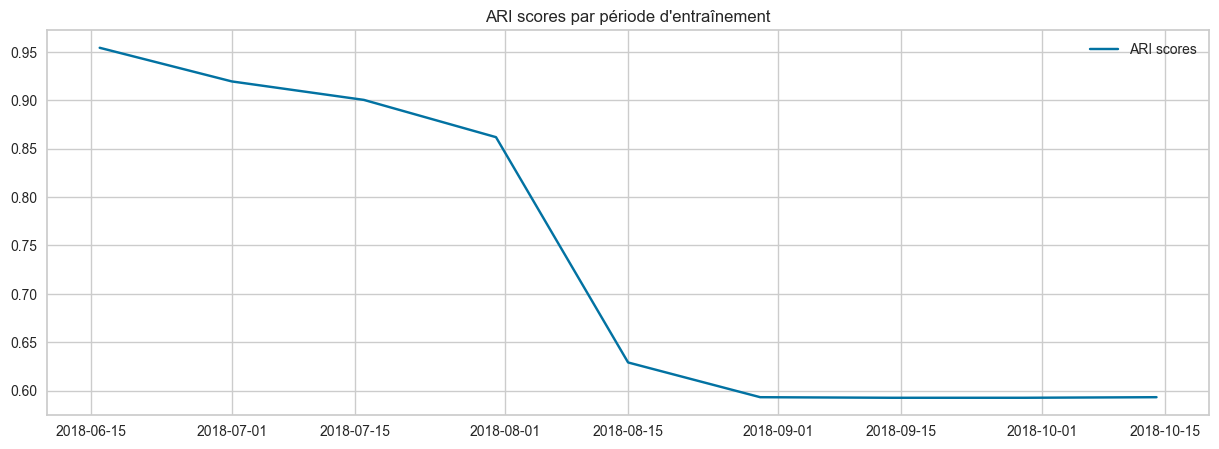

In [81]:
plt.figure(figsize=(15,5))
sns.lineplot(rand_scores)
plt.title("ARI scores par période d'entraînement")
plt.show()

Avec un modèle entraîné avec 2.5 ans de données, un nouvel entraînement sera nécessaire au bout de 2 mois.